# Retrying to Pac-man

Esta notebook es una continuación del trabajo final de *Procesos Markovianos para el Aprendizaje Automatico (2019)*.

> * TP Final - Procesos Markovianos para el Aprendizaje Automatico - 2019 1C
>
> https://github.com/LecJackS/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C-w.o.heavy-history-

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Retrying-to-Pac-man" data-toc-modified-id="Retrying-to-Pac-man-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Retrying to Pac-man</a></span></li><li><span><a href="#Statistics" data-toc-modified-id="Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Statistics</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Experimento-&quot;learning-rate&quot;" data-toc-modified-id="Experimento-&quot;learning-rate&quot;-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Experimento "<em>learning-rate</em>"</a></span></li><li><span><a href="#Experimento-&quot;número-de-procesos&quot;" data-toc-modified-id="Experimento-&quot;número-de-procesos&quot;-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Experimento "<em>número de procesos</em>"</a></span></li></ul></li></ul></li><li><span><a href="#Rewards-and-Expected-Reward-Count" data-toc-modified-id="Rewards-and-Expected-Reward-Count-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Rewards and <em>Expected Reward Count</em></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Sobre-el-código" data-toc-modified-id="Sobre-el-código-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Sobre el código</a></span></li></ul></li></ul></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimizer</a></span></li><li><span><a href="#Entrada" data-toc-modified-id="Entrada-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Entrada</a></span></li><li><span><a href="#Skip-Frame" data-toc-modified-id="Skip-Frame-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Skip Frame</a></span></li><li><span><a href="#LSTM-+-Reciclaje-+-Finetunning" data-toc-modified-id="LSTM-+-Reciclaje-+-Finetunning-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>LSTM + Reciclaje + <em>Finetunning</em></a></span></li><li><span><a href="#Clamp-Critic-(Value-Function)" data-toc-modified-id="Clamp-Critic-(Value-Function)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Clamp Critic (Value Function)</a></span><ul class="toc-item"><li><span><a href="#Cotas-dinámicas" data-toc-modified-id="Cotas-dinámicas-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Cotas dinámicas</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Problema:" data-toc-modified-id="Problema:-8.1.0.1"><span class="toc-item-num">8.1.0.1&nbsp;&nbsp;</span>Problema:</a></span></li><li><span><a href="#Solución:" data-toc-modified-id="Solución:-8.1.0.2"><span class="toc-item-num">8.1.0.2&nbsp;&nbsp;</span>Solución:</a></span></li></ul></li><li><span><a href="#Normalizando-recompensas" data-toc-modified-id="Normalizando-recompensas-8.1.1"><span class="toc-item-num">8.1.1&nbsp;&nbsp;</span>Normalizando recompensas</a></span></li></ul></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Clamp-on-loss" data-toc-modified-id="Clamp-on-loss-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Clamp on loss</a></span></li><li><span><a href="#Clamp-on-Critic-value" data-toc-modified-id="Clamp-on-Critic-value-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Clamp on Critic value</a></span></li><li><span><a href="#Tanh-+-Normalization" data-toc-modified-id="Tanh-+-Normalization-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Tanh + Normalization</a></span></li><li><span><a href="#Tanh-+-Normalization-w/-maxGt-decay" data-toc-modified-id="Tanh-+-Normalization-w/-maxGt-decay-9.4"><span class="toc-item-num">9.4&nbsp;&nbsp;</span>Tanh + Normalization w/ maxGt decay</a></span></li></ul></li><li><span><a href="#Resultados" data-toc-modified-id="Resultados-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Resultados</a></span></li><li><span><a href="#Código" data-toc-modified-id="Código-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Código</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Test</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Video:" data-toc-modified-id="Video:-11.1.0.1"><span class="toc-item-num">11.1.0.1&nbsp;&nbsp;</span>Video:</a></span></li></ul></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Train</a></span></li></ul></li><li><span><a href="#Berkeley-Pac-man" data-toc-modified-id="Berkeley-Pac-man-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Berkeley Pac-man</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Entrada-a-la-red-neuronal" data-toc-modified-id="Entrada-a-la-red-neuronal-12.0.1"><span class="toc-item-num">12.0.1&nbsp;&nbsp;</span>Entrada a la red neuronal</a></span></li></ul></li></ul></li><li><span><a href="#Código" data-toc-modified-id="Código-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Código</a></span><ul class="toc-item"><li><span><a href="#Test" data-toc-modified-id="Test-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>Test</a></span></li></ul></li><li><span><a href="#Conclusión" data-toc-modified-id="Conclusión-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Conclusión</a></span></li></ul></div>

En los meses pasados, luego de la entrega, seguí realizando pruebas para asegurarme que el algoritmo funcione (algo que **no** fue claramente demostrado en la entrega anterior).

Para eso se utilizó  [un nuevo environment de pacman (Ms Pac-man)](https://gym.openai.com/envs/MsPacman-v0/) que permitiera realizar experimentos a mayor velocidad.

![mspacman.png](./img/mspacman.png)

De esta forma se pudieron realizar ajustes que **demostraron buenos resultados** en el juego, **generalizando también** al lento pacman de Berkeley.

A continuación, una lista de correcciones y resultados obtenidos a partir de este nuevo entorno.

# Statistics

Una **prioridad** para esta serie de experimentos fue tener un **mayor grado de información** en cuanto a los resultados de distintos episodios en el tiempo.

Para eso se agregaron las siguientes estadísticas:

* **Promedio (mean)** de rewards acumulados en **últimos 100 episodios**
* **Mediana** del reward acumulado en los **últimos 100 episodios**
* **Desviación estándar** de rewards acumulados en últimos **100 episodios**
* ***"Mediana-estándar"***, como la mediana menos la media sobre desviación estándar $\frac{\text{median}-\text{mean}}{\sigma}$.
  
  A modo de combinar en un mismo plot los rewards promedios por cantidad (mediana) y por valor (mean).
  

### Experimento "*learning-rate*"

Se compararon 3 valores de step size diferentes:

* lr: $10^{-3}$ - ***Rojo***
* lr: $10^{-4}$ - ***Naranja***
* lr: $10^{-5}$ - ***Azul***

![comp-lr.png](./img/comp-lr.png)

![comp-lr-smooth.png](./img/comp-lr-smooth.png)

Ésto dió bastante certeza en que usar un lr de $10^{-4}$ como se venía haciendo, era lo indicado.

Búsquedas más finas no mostraron grandes diferencias, aunque fueron pruebas no tan extensivas en el tiempo.

### Experimento "*número de procesos*"

Un hyperparámetro que agrega A3C es la **cantidad de procesos asincrónicos** a ejecutar.

Se comparó **1 vs 6 procesos durante varios días**.

Los resultados fueron en favor de una mayor cantidad de procesos.

![comp-num-procesos.png](./img/comp-num-procesos.png)
(azul: 6; gris: 1)

# Rewards and *Expected Reward Count*

Como Vlad Mnih menciona en el siguiente video, simplificar los rewards *recortándolos* en valores estándar como -1,0,1 **facilita** la solución del problema para el agente en muchos casos, ya que **convierte el objetivo en obtener más cantidad de veces** rewards, distinto a *mayor reward*, donde existen distintos valores posible para el reward (ej. pacman: +500, +10, +1, 0, -1, -500), y sus combinaciones al calcular $G_t$ puede dar valores parecidos, a partir de combinaciones muy diferentes.

In [3]:
from IPython.display import HTML
# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/-mhBD8Frkc4?start=5520" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')
#@1:32:00 https://youtu.be/-mhBD8Frkc4?t=5520

En otras palabras, se **maximiza la esperanza de la *cantidad* de rewards recibidos** (*expected reward count*).

|   +500  |  +10   |  0 |  -1 |    -500|
|------|------|------|------|------|
|  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |
|   +1  | +1 |   0  |0|   0  | 0 | 

Solo esta modificación en el código produjo rápidos resultados, lo cuál tiene sentido para pacman, donde cada pellet y ganar el juego es ahora un +1, y el maximo puntaje será comer todas las pellets (y los fantasmas si *scared*).

![pacman-episode-1.gif](./img/pacman-episode-1.gif)

A pesar de haber aprendido bastante bien a recoger las pellets de un mapa de 14x14, demuestra poca cautela con los fantasmas, lo que indicó que podría ser conveniente agregar un valor negativo para el evento en el que hace contacto, y pierde.

|   +500  |  +10   |  0 |  -1 |    -500|
|------|------|------|------|------|
|  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |  $\downarrow$  |
|   +1  | +1 |   0  |  0  | -1 | 

Esta modificación no produjo ningún cambio en el comportamiento de Pac-man, lo que indica la necesidad de una mayor exploración en los valores de los hiperparámetros, o solo más tiempo de entrenamiento.

### Sobre el código

Gym contiene un conveniente paquete de *Wrappers* que permiten envolver al *environment* luego de creado con *gym.make('MsPacman-v0')* modificando funciones como *environment.step(action)* para que devuelva un reward modificado desde cualquier otro lado que sea llamada: 

>    class UnitReward_cs188x(Wrapper):
>        def __init__(self, env=None, monitor=None):
>            super(UnitReward_cs188x, self).__init__(env)
>            
>        def step(self, action):
>            state, reward, done, info = self.env.step(action)
>            if reward > 0:
>                reward = 1.
>            else:
>                reward = 0.
>
>            return state, reward, done, info



# Optimizer

Se implementó ***RMSProp con parámetros compartidos*** para contrastar con los de ***Adam***, previamente utilizado.

No se observó ninguna diferencia en largos experimentos con los mismos hyperparámetros.

# Entrada

Se modificó el tipo de ***entrada a la red neuronal***.

* Manteniendo las **4 rotaciones** de 90°
* Asignando a cada rotación, los valores (intensidades) de su **canal de color correspondiente (RGB)**, y *grayscale* para la última imagen.

![pacman-episode-4.gif](./img/pacman-episode-4.gif)

Originalmente se pensó como alternativa a buscar manualmenmte el mejor equilibrio de grises para la red (variando mean, varianza, etc).

Las primeras pruebas fueron usando ***ms-pacman de Atari***, sin las rotaciones (ya que tiene información extra en la parte inferior de la pantalla) pero usando el mismo tipo de división de colores:

![mspacman-episode-4.gif](./img/mspacman-episode-4.gif)

Partiendo de **pesos ya entrenados** solo con escala de grises, el agente mostró una rápida adaptación al nuevo tipo de entrada:

![learning-after-colours.png](./img/learning-after-colours.png)

# Skip Frame

Otra característica mencionada pero poco explorada en el anterior proyecto, fue el uso de ***skip frame***.

La primera impresión al ejecutar ms-pacman con el mismo modelo anterior, fue de que **la simulación también era lenta**.

El motivo fue el **alto frame rate**, con el cual cada frame era un estado que debía procesarse por la NN.

Para eso se utiliza ***skip frame*** que elije, combina y/o saltea frames consecutivos.

Para DQN, la entrada a la red neuronal fueron 4 frames apilados:

    [max(T-1,  T),
     max(T+3,  T+4),
     max(T+7,  T+8),
     max(T+11, T+12)]
     
Donde `max(T-1, T)` es el máximo *elementwise* entre las matrices de píxeles de **dos frames consecutivos**.

**Descartando otros 2** frames luego de cada operación max().


Para pacman de Atari, se utilizó un filtro similar al de DQN, con una diferencia:

* con 1 solo *skip frame*

        [max(T,    T+1),
         max(T+3,  T+4),
         max(T+6,  T+7),
         max(T+9,  T+10)]

* Sin *skip frames*, solo máximo entre cada dos

        [max(T,    T+1),
         max(T+2,  T+3),
         max(T+4,  T+5),
         max(T+6,  T+7)]

La siguiente imagen muestra la entrada de píxeles de los 4 estados a la red neuronal, calculando máximo entre cada dos, y salteando 1 frame.

![dqn-skip-frame.png](./img/dqn-skip-frame.png)

Se determinó que **el frame descartado limitaba la capacidad de reacción del agente**, por lo que se decidió por no usar skip frames.

El cambio de entrada produjo resultados negativos (esperados) al agente **ya entrenado** con la entrada anterior.

En unas horas de entrenamiento volvió a los valores anteriores y los siguió superando.

# LSTM + Reciclaje + *Finetunning*

Una vez entrenado el agente de modelo neuronal **lineal**, se decidió probar nuevamente una capa LSTM en su lugar.

Para ello:

1. Se **cargaron los pesos ya entrenados** en el modelo **lineal**
2. **Se *"congelaron"* las capas convolucionales** para mantener los filtros/features aprendidos
3. **Se entrenó el resto** del modelo neuronal **hasta ver mejoras** en el resultado
4. Se descongelaron todas las capas y siguió normalmente con el entrenamiento en conjunto

A continuación, el nuevo modelo neuronal con LSTM y las capas convolucionales congeladas siendo entrenado, partiendo de los pesos del modelo lineal:

![lstm-learn.png](./img/lstm-learn.png)

Last but not least
# Clamp Critic (Value Function)

En la sección ["Estrategias de modelado"](https://github.com/LecJackS/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C-w.o.heavy-history-/blob/master/Very%20quick%20roadmap%20to%20Asynchronous%20Advantage%20Actor%20Critic.ipynb#Estrategias-de-modelado) del trabajo anterior, se notaron **picos muy grandes** en el error (*loss*) calculado, por lo que se optó por poner topes en el mismo de $\frac{1}{\text{step-size}}$, sin conocer el motivo de ellos.

El problema real fue que la **Value Function (*Critic*)** era una salida en la red neuronal que entregaba valores reales, sin cotas de ningún tipo.

Recordando el modelo:

![actor-critic-model.png](./img/actor-critic-model.png)

Dado que el error total se calcula como:

>    total_loss = -actor_loss + ***critic_loss*** - opt.beta * entropy_loss

Donde *critic_loss* es:

>    critic_loss = critic_loss + (***(Gt - value)^2***) / 2

Esa **diferencia al cuadrado** ($(G_t - V_t)^2$)  era la causante de tales magnitudes.

Una solución encontrada, fue **acotar los valores de la value function** $V_t$ entre $\left[0,\, 20\right]$.

La magnitud $20$ surge de ver los plots de rewards promedio del juego con valores cercanos a 20, y 30 si casi ganando el episodio.

El rango de esa magnitud $G_t$ **será particular de cada juego**, como también **de cada instancia en el tiempo** (distintas para un agente bien entrenado, que para uno random).

## Cotas dinámicas

Una mejor solución fue determinar la magnitud de la cota, como el máximo/mínimo Gt obtenido hasta el momento.

> **Inicia** con **cotas para el Crítico** de $[-1, \,1]$.
>
> Al finalizar cada episodio ($n$ steps), **se calcula Gt** de los datos guardados
>
> $G_t^{(n)} = R_{t+1} + \gamma\, R_{t+2}\, + \gamma^2\, R_{t+3} + \, ... \, + \, \gamma^{n-1} R_{t+n} + \gamma^{n}\, \tilde{V}(S_{t+n})$
>
>     1. Si (Gt > cotaMax): 
>
>        cotaMax = Gt
>
>     2. Si (Gt < cotaMin): 
>
>        cotaMin = Gt

Luego, estimo $V_t$ usando red neuronal, y recorto con cotas:

>      logits, value = local_model(state)
>
>      value.clamp(cotaMin, cotaMax)

De esta forma, los valores máximo/mínimo del Crítico aumentarán **a medida que se vean puntajes más altos**.

#### Problema:

* Las **cotas no forman parte del modelo** neuronal, el cual tendrá **como salida valores no-acotados**, que se recortarán, y **a partir de estos valores modificados se calculará el error** (***loss***) con el cual se actualizarán los pesos.

#### Solución:

* Agregar una ***función tangente hiperbólica (tanh)*** al modelo neuronal, de forma que a la salida sean valores entre -1 y 1, con un mejor gradiente con el cual actualizar los pesos.

### Normalizando recompensas

Tener una salida entre $-1$ y $+1$ permite simplificar el problema devolviendo estimaciones cercanas a $+1$ para estados favorables, y a $-1$ para los que no.

Es necesario ahora normalizar acorde el resto de las recompensas, que siguen siendo valores entre $0$ y $\approx30$.

Para ello, cada reward $R_{t+1}$ obtenido luego de cada acción $A_t$ es dividido por el máximo $G_t$ visto hasta el momento

    state, reward, done, _ = env.step(action)
    reward = reward / max_Gt
    
Siendo:
    
    R = reward + gamma * R
    max_Gt = max(max_Gt, abs(R))
    
Con esto se soluciona tanto el problema de los **valores extremos del Crítico**, como también la **diferencia en órden de magnitud del error del Actor**:

$$loss_{critic} = loss_{critic} + \frac{1}{2}((G_t - V_t)^ 2)$$

Ya que:

$V_t \in [-1, 1]$ , pues es la imagen de una Tanh

y 

$G_t \in [-1, 1]$ , pues es siempre dividido por el ***máximo*** $G_t$ observado hasta el momento.

# Plots

de los errores calculados por los 3 métodos mencionados.

**Observar:** Escalas en el eje Y (error)

## Clamp on loss 
![loss-before-clamp.png](./img/loss-before-clamp.png)

## Clamp on Critic value
![loss-after-clamp.png](./img/loss-after-clamp.png)

## Tanh + Normalization
![total-loss-normalized.png](./img/total-loss-normalized.png)

## Tanh + Normalization w/ maxGt decay

    # on each time step, decay max_Gt over time to adjust to actual Gt scale
    max_Gt = max_Gt * 0.9999
    

          
![total-loss-decay.png](./img/total-loss-decay.png)

Formado por la suma de:

1. **+ Critic** loss
2. **- Actor** loss
3. **- Entropy** loss * 0.01

![critic-loss-decay.png](./img/critic-loss-decay.png)
![actor-loss-decay.png](./img/actor-loss-decay.png)
![entropy-loss-decay.png](./img/entropy-loss-decay.png)

  - `max_Gt` con valor inicial `max_Gt=10`, con `decay=0.9999`:
![maxGt-decay.png](./img/maxGt-decay.png)

Plots en orden de aparición:

  1. `Acum_Reward`: **Recompensa** por cada episodio **sin normalizar**
  2. `Gt`: **Recompensa** por cada episodio **normalizada** con `max_Gt`
  3. `Last100_mean`: **Recompensa promedio** de los últimos 100 ***episodios***
  4. `Last100_median`: **Mediana** de las últimas 100 ***recompensas***

![returns-decay.png](./img/returns-decay.png)


# Resultados

Este último cambio volvió al algoritmo más **robusto** y **predecible**, pudiendo ajustar mejor los hiperparámetros al ritmo de avances en el aprendizaje (mayores puntajes promedio y mediana).

# Código

## Test

El siguiente código muestra un agente **entrenado durante varios días** en *Ms Pac-man de Atari*.

Si es la primera vez que se ejecuta el código, descargará un archivo el archivo de 2.7MB con los pesos guardados (dos celdas más abajo se puede en video).

In [1]:
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
saved_path = './trained_models'
layout = 'atari'
saved_model = "{}/gym-pacman_{}".format(saved_path, layout)
print("Checking if saved model: {} ...".format(saved_model))
if not os.path.isfile(saved_model):
    try:
        import urllib.request
        print('File not found, downloading saved model...')
        url = 'https://github.com/LecJackS/trained-models/blob/master/gym-pacman/gym-pacman_atari?raw=true'
        file_name = 'gym-pacman_atari'
        urllib.request.urlretrieve(url, '{}/{}'.format(saved_path, file_name))
        print('Download done.')
    except:
        print("Something wrong happened, couldn't download model")
else:
    print('Already there.')

Checking if saved model: ./trained_models/gym-pacman_atari ...
Already there.


El juego consiste en devorar todas las pellets teniendo 3 vidas disponibles, siguiendo las [reglas usuales de Pac-man](https://en.wikipedia.org/wiki/Pac-Man_(Atari_2600)#Gameplay).

Si el juego parpadea, es porque completó el nivel.

$_\text{(si uno parpadea, se pierde el juego)}$

In [2]:
# Reset kernel to go to default directory
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
#os.chdir('./gym_pacman')

from test_agent import test
from argparse import Namespace
args = Namespace(layout='atari',
                 saved_path='trained_models',
                 num_games_to_play=10)
test(args)

Getting number of NN inputs/outputs for atari
Loading saved model: trained_models/gym-pacman_atari ...
Done.
 1: Done. #returns/#steps: 120 / 191 = 0.62827
 2: Done. #returns/#steps: 175 / 244 = 0.71721
 3: Done. #returns/#steps: 102 / 153 = 0.66667
 4: Done. #returns/#steps: 207 / 304 = 0.68092
 5: Done. #returns/#steps: 107 / 186 = 0.57527
 6: Done. #returns/#steps: 113 / 186 = 0.60753
 7: Done. #returns/#steps: 141 / 217 = 0.64977
 8: Done. #returns/#steps: 195 / 300 = 0.65000
 9: Done. #returns/#steps: 213 / 330 = 0.64545
10: Done. #returns/#steps: 160 / 235 = 0.68085
Number of tests completed.


#### Video:

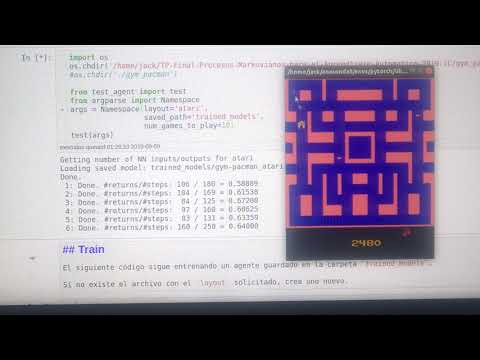

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('OwYbJGBBL64')

## Train

El siguiente código sigue entrenando un agente guardado en la carpeta `trained_models`.

Si no existe el archivo con el `layout` solicitado, crea uno nuevo y lo entrena desde cero.

Para ver las estadísticas en Tensorboard, correr:

>      tensorboard --logdir=alias:./tensorboard

In [3]:
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
#os.chdir('./gym_pacman')
from train import train
from argparse import Namespace
args = Namespace(beta =0.001,
                 gamma=0.9,
                 tau=1.0,
                 lr=3e-5,
                 layout='atari',
                 load_previous_weights=True,
                 num_processes=8,                # numero de procesos asincronicos
                 num_processes_to_render=1,     # numero de procesos a visualizar
                 use_gpu=False,
                 max_actions=200,
                 num_global_steps=5e9,
                 num_local_steps=50,     # async updates every
                 save_interval=25,
                 saved_path='trained_models',
                 log_path='tensorboard',
                 record=False)
print("Agent progress details are displayed on this jupyter notebook TERMINAL (not here)\n")
train(args)

Agent progress details are displayed on this jupyter notebook TERMINAL (not here)

Getting number of NN inputs/outputs for atari
Loading previous weights for atari... Done.


KeyboardInterrupt: 

# Berkeley Pac-man

Usando las mejoras implementadas en Ms Pac-man de Atari, se obtuvieron mejores resultados en el Pac-man de Berkeley.

Cada mapa de cada juego (episodio) se genera de forma aleatoria:

* Mapa de **14x14** celdas
* Cantidad de fantasmas entre **1 y 3**
* Cada fantasma $i$ es **creado** con una **agresividad aleatoria** $\in [0, 0.9]$ (acción aleatoria $A^-_i$ con $P(A^-_i) \in [1.0, 0.1]$)
* ***Pellets (food)*** ocuparán de manera aleatoria una **fracción del espacio** vacío $\in [0.1, 0.9]$
* **Posición de inicio** de todos los agentes es **aleatoria** (con una mínima distancia en favor de Pac-man)

### Entrada a la red neuronal 

* Tensor de dimensión $4 \times 84 \times 84$
* **Cada imagen** de $84 \times 84$ **corresponde al mismo frame** (sin *skip-frame*)
* Cada uno de los $4$ canales **corresponde a las intensidades** de ***RGB+Grayscale*** de los píxeles del juego en colores

![cs188x-pacman-episode.gif](./img/cs188x-pacman-episode.gif)



# Código

## Test

El siguiente código muestra un agente **entrenado durante varios días** en el [simulador de Pac-man de Berkeley](http://ai.berkeley.edu/project_overview.html).

Si es la primera vez que se ejecuta el código, descargará un archivo el archivo de 2.7MB con los pesos guardados (dos celdas más abajo se puede en video).

In [2]:
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
saved_path = './trained_models'
layout = 'atari'
saved_model = "{}/gym-pacman_{}".format(saved_path, layout)
print("Checking if saved model: {} ...".format(saved_model))
if not os.path.isfile(saved_model):
    try:
        import urllib.request
        print('File not found, downloading saved model...')
        url = 'https://github.com/LecJackS/trained-models/blob/master/gym-pacman/gym-pacman_cs188x?raw=true'
        file_name = 'gym-pacman_cs188x'
        urllib.request.urlretrieve(url, '{}/{}'.format(saved_path, file_name))
        print('Download done.')
    except:
        print("Something wrong happened, couldn't download model")
else:
    print('Already there.')

Checking if saved model: ./trained_models/gym-pacman_atari ...
Already there.


In [1]:
# Reset kernel to go to default directory
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
#os.chdir('./gym_pacman')

from test_agent import test
from argparse import Namespace
args = Namespace(layout='cs188x',
                 saved_path='trained_models',
                 num_games_to_play=10)
test(args)

Getting number of NN inputs/outputs for layout cs188x
Loading saved model: trained_models/gym-pacman_cs188x ...
Done.
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
Pacman died! Score: -486
PENALTY_:  0
real reward: -491.0
reward:  -1.0
 1: Done. #returns/#steps:   0 /   6 = 0.00000
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: 9.0
reward:  1.0
PENALTY_:  0
real reward: -1.0
reward:  0.0
PENALTY_:  0
real reward

KeyboardInterrupt: 

In [ ]:
import os
os.chdir('/home/jack/TP-Final-Procesos-Markovianos-para-el-Aprendizaje-Automatico-2019-1C/gym_pacman')
#os.chdir('./gym_pacman')
from train import train
from argparse import Namespace
args = Namespace(beta =0.003,
                 gamma=0.9,
                 tau=1.0,
                 lr=3e-4,
                 layout='cs188x',
                 load_previous_weights=True,
                 num_processes=8,                # numero de procesos asincronicos
                 num_processes_to_render=1,     # numero de procesos a visualizar
                 use_gpu=False,
                 max_actions=200,
                 num_global_steps=5e9,
                 num_local_steps=100,     # async updates every
                 save_interval=25,
                 saved_path='trained_models',
                 log_path='tensorboard',
                 record=False)
print("Agent progress details are displayed on this jupyter notebook TERMINAL (not here)\n")
train(args)

Agent progress details are displayed on this jupyter notebook TERMINAL (not here)

Getting number of NN inputs/outputs for layout cs188x
Loading previous weights for cs188x... Done.


---

# Conclusión

Esta segunda parte del trabajo permitió familiarizarme con varios conceptos que a su vez sirvieron de guía a la hora de corregir y explorar soluciones.

* El poder computacional sigue siendo un limitante, sobre todo para los cambios en el algoritmo que requieren modificaciones a los hiperparámetros.


* Encontrar soluciones a juegos de Atari es *cool*, pero problemas o juegos más simples formulados con objetivos específicos pueden dar respuestas mucho más velozmente y en la dirección correcta.

  Un ejemplo de esto es [*bsuite*](https://github.com/deepmind/bsuite) va en ese camino, como varios otros que aparecen a causa de la demanda actual del área de RL, que buscan estándares sobre los cuales calificar distintos algoritmos.
  
  
* Juegos diferentes pueden ser resueltos con el mismo algoritmo, pero ambos deberán ser entrenados desde cero (no hay transferencia de conocimiento en "acciones" generales/básicas).


* Implementar estos algoritmos demanda mucho trabajo de calibración para hacer coincidir las partes. 

  Teniendo formas estándares de evaluar algoritmos, y algoritmos optimizados de cada tipo, sería una buena estrategia partir de éstos últimos para adaptarlos a nuestras necesidades con modicaciones o nuevos algoritmos, siendo eficientes en el manejo del tiempo.

![final-fantasy.gif](./img/final-fantasy.gif)